In [1]:
! pip install tensorflow

In [84]:
! pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [85]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import shutil
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap.umap_ as umap
import seaborn as sns

# Сбор данных

In [4]:
! pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 7.2 MB/s eta 0:00:00


In [5]:
from dagshub.streaming import DagsHubFilesystem

fs = DagsHubFilesystem(".", repo_url="https://dagshub.com/DagsHub-Datasets/voice_gender_detection")
#fs.listdir("males")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=d24067a7-66f5-46c4-b471-aa2ac1339744&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=4873bf001ccfac7f55a64a18a81f9efd29318d76254ae8cc2f824efda549b032




Output()

Accessing as startsevaarina4

In [7]:
AUDIO_PATH = "M_F_dataset"
SAMPLE_RATE = 16000
MFCC_FEATURES = 40
MAX_AUDIO_FILES = 500
MAX_FILES_PER_GENDER = MAX_AUDIO_FILES // 2

os.makedirs(AUDIO_PATH, exist_ok=True)

def download_audio_from_dagshub():
    try:
        fs = DagsHubFilesystem(".", repo_url="https://dagshub.com/DagsHub-Datasets/voice_gender_detection")
        if not os.path.exists(AUDIO_PATH):
            os.makedirs(AUDIO_PATH)

        for gender in ["males", "females"]:
            gender_path = os.path.join(AUDIO_PATH, gender)
            os.makedirs(gender_path, exist_ok=True)
            count = 0
            for file_name in fs.listdir(gender):
                if count >= MAX_FILES_PER_GENDER:
                    break
                source_path = os.path.join(gender, file_name)
                target_path = os.path.join(gender_path, file_name)
                with fs.open(source_path, "rb") as src_file:
                    with open(target_path, "wb") as dst_file:
                        shutil.copyfileobj(src_file, dst_file)
                count += 1
                print(f"Downloaded: {file_name} to {target_path}")
    except Exception as e:
        print(f"Error downloading audio files: {e}")

download_audio_from_dagshub()

Downloaded: 1863.wav to M_F_dataset/males/1863.wav
Downloaded: 193.wav to M_F_dataset/males/193.wav
Downloaded: 1846.wav to M_F_dataset/males/1846.wav
Downloaded: 1750.wav to M_F_dataset/males/1750.wav
Downloaded: 2044.wav to M_F_dataset/males/2044.wav
Downloaded: 2275.wav to M_F_dataset/males/2275.wav
Downloaded: 1043.wav to M_F_dataset/males/1043.wav
Downloaded: 1461.wav to M_F_dataset/males/1461.wav
Downloaded: 1955.wav to M_F_dataset/males/1955.wav
Downloaded: 2041.wav to M_F_dataset/males/2041.wav
Downloaded: 2148.wav to M_F_dataset/males/2148.wav
Downloaded: 2717.wav to M_F_dataset/males/2717.wav
Downloaded: 3076.wav to M_F_dataset/males/3076.wav
Downloaded: 1435.wav to M_F_dataset/males/1435.wav
Downloaded: 2297.wav to M_F_dataset/males/2297.wav
Downloaded: 2526.wav to M_F_dataset/males/2526.wav
Downloaded: 1892.wav to M_F_dataset/males/1892.wav
Downloaded: 3132.wav to M_F_dataset/males/3132.wav
Downloaded: 2099.wav to M_F_dataset/males/2099.wav
Downloaded: 2378.wav to M_F_datas

# Препроцессинг

Датасет состоит из разговора мужчин и разговора женщин. Задача данной лабы - построить модель, которая научится определять пол говорящего человека.

У аудиофайлов уже есть разметка: они лежат в двух папках, название которых соответствую полу говорящего человека.

In [10]:
datadir = "M_F_dataset"

mfcc_features = []
labels = []

for gender in os.listdir(datadir):
    gender_path = os.path.join(datadir, gender)

    if os.path.isdir(gender_path):

        for file_name in os.listdir(gender_path):
            file_path = os.path.join(gender_path, file_name)

            if os.path.isfile(file_path):
                try:
                    file, sr = librosa.load(file_path, sr=None)
                    mfcc = librosa.feature.mfcc(y=file, sr=sr, n_mfcc=40)
                    mfcc_mean = np.mean(mfcc, axis=1)
                    mfcc_features.append(mfcc.T)
                    labels.append(gender)
                except Exception as e:
                    print(f"Ошибка в обработке {file_path}: {e}")

#mfcc_features= np.array(mfcc_features)
labels = np.array(labels)

#print(f"Собрано эмбеддингов: {mfcc_features.shape[0]}")
print(f"Примеры меток: {set(labels)}")

Примеры меток: {'males', 'females'}


In [11]:
#np.save("mfcc_features.npy", mfcc_features)
np.save("labels.npy", labels)

Возьмем задачу реализации LTSM модели.Преобразуем метки в числовой формат, приведем последовательности к одинаковой длине, преобразуем метки в one-hot encoding

In [12]:
max_seq_length = min(max([mfcc.shape[0] for mfcc in mfcc_features]), 100)

#X = pad_sequences(mfcc_features, maxlen=max_seq_length, padding="post", dtype="float32")

#unique_labels = list(set(labels))
#label_to_index = {label: i for i, label in enumerate(unique_labels)}
#y = np.array([label_to_index[label] for label in labels])

#X_train, X_val, y_train, y_val = train_test_split(
#    X, y, test_size=0.19, random_state=42, stratify=y
#)

#y_train = to_categorical(y_train, num_classes=len(unique_labels))
#y_val = to_categorical(y_val, num_classes=len(unique_labels))

print(f"X_train.shape = {X_train.shape}")
print(f"X_val.shape = {X_val.shape}")

X_train.shape = (405, 100, 40)
X_val.shape = (95, 100, 40)


In [13]:
from collections import Counter
print(Counter(labels))

Counter({'males': 250, 'females': 250})


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_seq_length = min(max([mfcc.shape[0] for mfcc in mfcc_features]), 100)
#X = pad_sequences(mfcc_features, maxlen=max_seq_length, padding="post", dtype="float32")

unique_labels = list(set(labels))
label_to_index = {label: i for i, label in enumerate(unique_labels)}
#y = np.array([label_to_index[label] for label in labels])

#X_train, X_val, y_train, y_val = train_test_split(
#    X, y, test_size=0.19, random_state=42, stratify=y
#)

#y_train = to_categorical(y_train, num_classes=len(unique_labels))
#y_val = to_categorical(y_val, num_classes=len(unique_labels))

print(f"X_train.shape = {X_train.shape}")
print(f"X_val.shape = {X_val.shape}")

X_train.shape = (405, 100, 40)
X_val.shape = (95, 100, 40)


# Реализация модели и ее обучение

In [66]:
n_mfcc = 40
input_dim = n_mfcc
num_classes = len(unique_labels)

______________________________________________________________________________________________________________________________

In [75]:
X = pad_sequences(mfcc_features, maxlen=max_seq_length, padding="post", dtype="float32")
y = np.array([label_to_index[label] for label in labels])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.19, random_state=42, stratify=y
)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train)
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class AudioClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AudioClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.05)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, (hidden, _) = self.lstm(x)
        hidden = hidden[-1]
        x = self.dropout1(hidden)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def extract_embeddings(self, x):
        lstm_out, (hidden, _) = self.lstm(x)
        hidden = hidden[-1]
        x = self.fc1(hidden)
        return torch.relu(x)

hidden_dim = 64
model = AudioClassifier(input_dim, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


In [73]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()

        outputs = model(X_batch).view(-1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()  #логиты в бинарные предсказания
        correct_predictions += (predicted == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


def test(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch).view(-1)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioClassifier(input_dim=n_mfcc, hidden_dim=64).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 40
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = test(model, val_loader, criterion, device)

    print("-------------------------------------------------------------------------------------------")
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


-------------------------------------------------------------------------------------------
Epoch 1/40:
Train Loss: 0.6901, Train Accuracy: 0.4889
Val Loss: 0.6867, Val Accuracy: 0.5789
-------------------------------------------------------------------------------------------
Epoch 2/40:
Train Loss: 0.6731, Train Accuracy: 0.6765
Val Loss: 0.6779, Val Accuracy: 0.6316
-------------------------------------------------------------------------------------------
Epoch 3/40:
Train Loss: 0.6545, Train Accuracy: 0.7160
Val Loss: 0.6621, Val Accuracy: 0.6421
-------------------------------------------------------------------------------------------
Epoch 4/40:
Train Loss: 0.6158, Train Accuracy: 0.8049
Val Loss: 0.6301, Val Accuracy: 0.7579
-------------------------------------------------------------------------------------------
Epoch 5/40:
Train Loss: 0.5638, Train Accuracy: 0.8321
Val Loss: 0.5958, Val Accuracy: 0.7263
----------------------------------------------------------------------

# Получение эмбеддингов и визуализация

In [77]:
def get_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            embedding = model.extract_embeddings(X_batch)
            embeddings.append(embedding.cpu().numpy())
            labels.append(y_batch.cpu().numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

train_embeddings, train_labels = get_embeddings(model, train_loader, device)
val_embeddings, val_labels = get_embeddings(model, val_loader, device)

**t-SNE для снижения размерности**

In [88]:
def visualize_embeddings_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        hue=labels,
        palette="tab10",
        legend="full"
    )
    plt.title(title)
    plt.show()

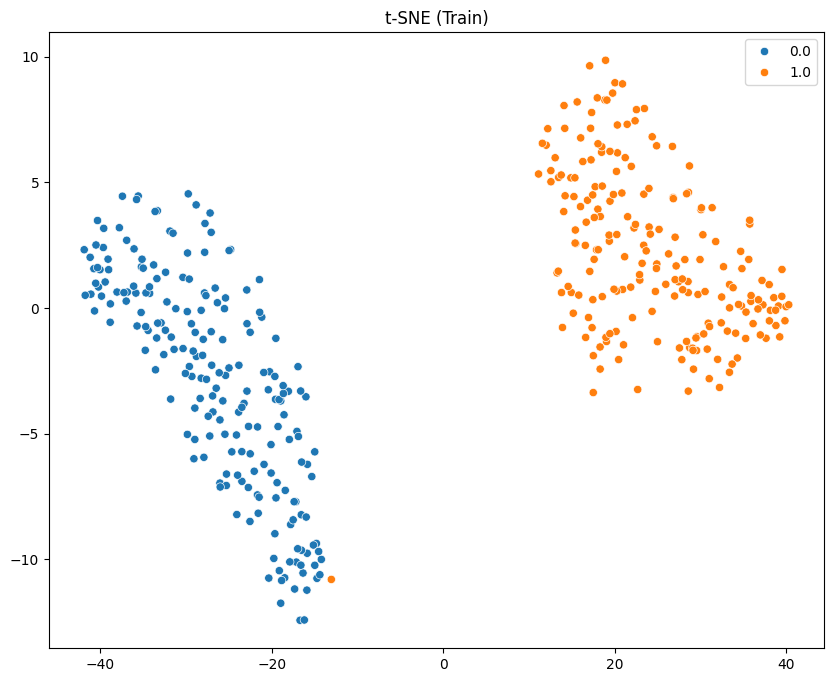

In [89]:
visualize_embeddings_tsne(train_embeddings, train_labels, title="t-SNE (Train)")

**UMAP для снижения размерности**

In [90]:
def visualize_embeddings_umap(embeddings, labels, title):
    reducer = umap.UMAP(random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        hue=labels,
        palette="tab10",
        legend="full"
    )
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


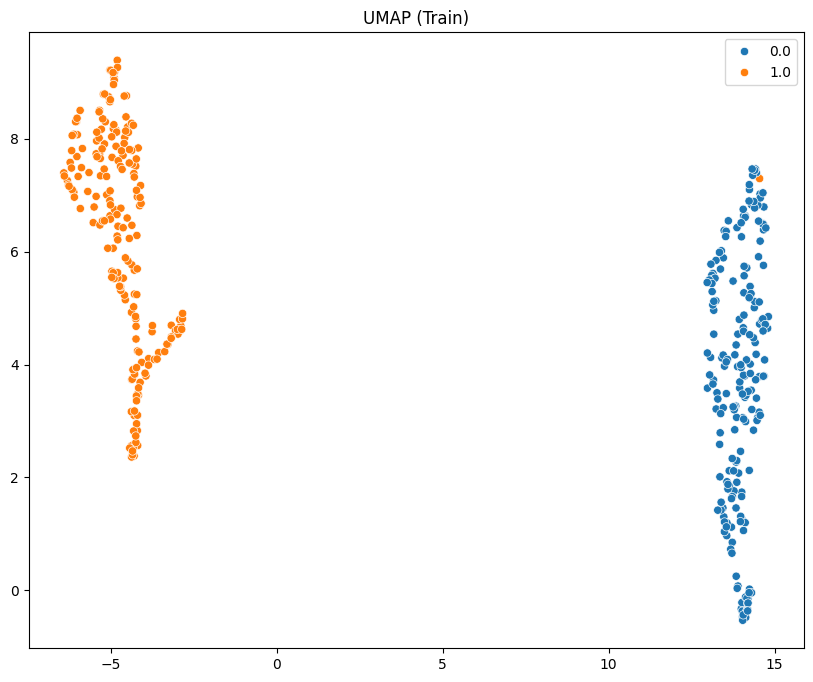

In [91]:
visualize_embeddings_umap(train_embeddings, train_labels, title="UMAP (Train)")